In [1]:
! chmod 600 /content/kaggle.json

! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d rober2598/madrid-weather-dataset-by-hours-20192022

100% 379k/379k [00:00<00:00, 742kB/s]
100% 379k/379k [00:00<00:00, 741kB/s]


In [2]:
import zipfile
zip_file = zipfile.ZipFile('/content/madrid-weather-dataset-by-hours-20192022.zip')
zip_file.extractall('/tmp/')

In [3]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Bidirectional
import matplotlib.pyplot as plt
import tensorflow as tf

In [123]:
data_train = pd.read_csv('/tmp/weather_madrid_2019-2022.csv')
data_train = data_train.iloc[:5000]
data_train

,Unnamed: 0,time,temperature,wind_speed,wind_direction,humidity,barometric_pressure,solar_radiation,precipitation
0,0,2019-01-01 00:59:59,3.1,0.65,64.0,50.0,949.0,0.0,0.0
1,1,2019-01-01 01:59:59,2.9,0.95,32.0,49.0,949.0,0.0,0.0
2,2,2019-01-01 02:59:59,3.1,0.87,62.0,46.0,949.0,0.0,0.0
3,3,2019-01-01 03:59:59,1.9,0.73,75.0,51.0,949.0,0.0,0.0
4,4,2019-01-01 04:59:59,0.7,0.57,53.0,56.0,949.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
4995,651,2019-07-28 03:59:59,14.8,3.15,64.0,58.0,937.0,0.0,0.0
4996,652,2019-07-28 04:59:59,13.8,2.67,77.0,59.0,937.0,0.0,0.0
4997,653,2019-07-28 05:59:59,13.0,2.15,83.0,61.0,938.0,0.0,0.0
4998,654,2019-07-28 06:59:59,12.4,2.05,83.0,62.0,938.0,0.0,0.0


In [124]:
data_train.isnull().sum()

Unnamed: 0             0
time                   0
temperature            0
wind_speed             0
wind_direction         0
humidity               0
barometric_pressure    0
solar_radiation        0
precipitation          0
dtype: int64

In [125]:
data_train['Day'] = 1
data_train['time'] = pd.to_datetime( data_train['time'] , format="%Y/%m/%d")

data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Unnamed: 0           5000 non-null   int64         
 1   time                 5000 non-null   datetime64[ns]
 2   temperature          5000 non-null   float64       
 3   wind_speed           5000 non-null   float64       
 4   wind_direction       5000 non-null   float64       
 5   humidity             5000 non-null   float64       
 6   barometric_pressure  5000 non-null   float64       
 7   solar_radiation      5000 non-null   float64       
 8   precipitation        5000 non-null   float64       
 9   Day                  5000 non-null   int64         
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 390.8 KB


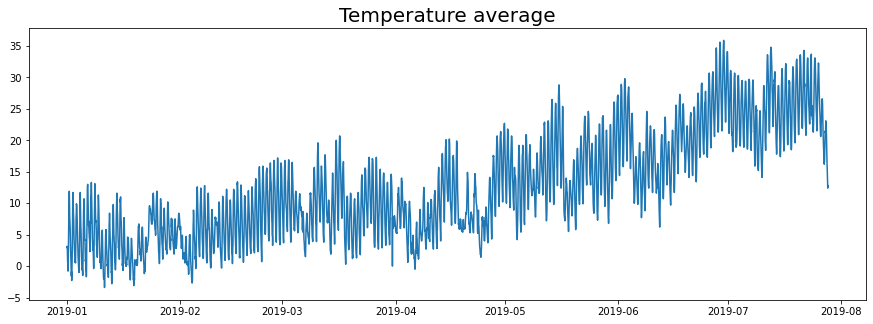

In [126]:
dates = data_train['time'].values
temp  = data_train['temperature'].values
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

In [127]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [128]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(temp, dates, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

4000 1000


In [129]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
data_scaled = scaler.fit_transform(x_train.reshape(-1,1)).reshape(-1)
threshold_mae = (data_scaled.max() - data_scaled.min()) * 0.1
threshold_mae

0.5288349889629116

In [130]:
tf.keras.backend.set_floatx('float64')
train_set = windowed_dataset(x_train, window_size=60, batch_size=4, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60)),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(8, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [131]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< threshold_mae):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

In [132]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae"])
history = model.fit(train_set,epochs=100,  batch_size=4, callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


985/985 [==============================] - 91s 81ms/step - loss: 0.5596 - mae: 0.9191
Epoch 2/100
985/985 [==============================] - 81s 82ms/step - loss: 0.2576 - mae: 0.5764
Epoch 3/100
985/985 [==============================] - 81s 82ms/step - loss: 0.2330 - mae: 0.5446
Epoch 4/100
985/985 [==============================] - ETA: 0s - loss: 0.2195 - mae: 0.5286
MAE of the model < 10% of data scale
985/985 [==============================] - 79s 80ms/step - loss: 0.2195 - mae: 0.5286
